In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [4]:
data=pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
data.info()
data.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


(200, 5)

In [6]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
print(data.isnull().sum())

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [11]:
data.drop('CustomerID',axis=1)

label= LabelEncoder()

data['Gender'] = label.fit_transform(data['Gender'])

In [12]:
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = iso_forest.fit_predict(data)
data = data[outliers == 1]  # Keep non-outliers
print("Number of outliers removed:", sum(outliers == -1))

Number of outliers removed: 20


In [13]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

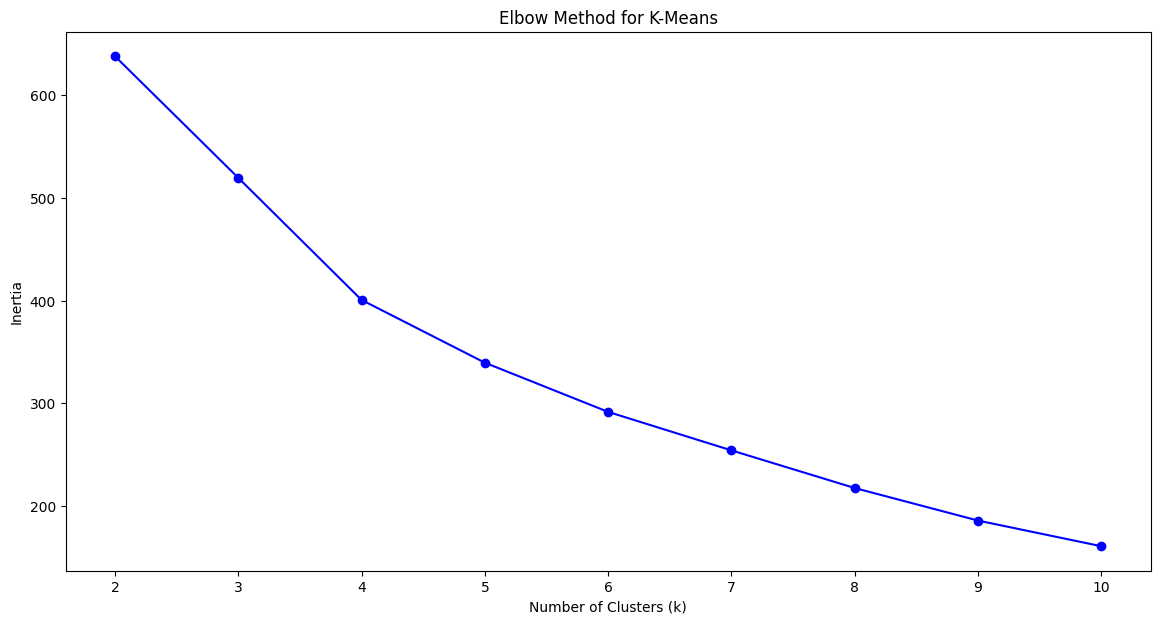

In [14]:
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)


# Plot Elbow and Silhouette
plt.figure(figsize=(14, 7))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')
plt.show()

In [15]:
kmeans = KMeans(n_clusters=5, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(scaled_data)
kmeans_silhouette = silhouette_score(scaled_data, kmeans.labels_)
print("K-Means Silhouette Score:", kmeans_silhouette)

K-Means Silhouette Score: 0.32133193071102284


In [21]:
dbscan = DBSCAN(eps=0.39, min_samples=5)
data['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_data)
if len(np.unique(dbscan.labels_[dbscan.labels_ != -1])) > 1:
    dbscan_silhouette = silhouette_score(scaled_data[dbscan.labels_ != -1], 
                                        dbscan.labels_[dbscan.labels_ != -1])
    print("DBSCAN Silhouette Score:", dbscan_silhouette)
else:
    print("DBSCAN produced too few clusters for silhouette score.")

DBSCAN Silhouette Score: 0.816340529301549


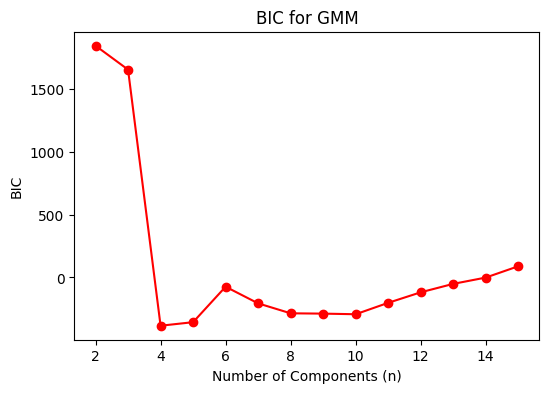

In [22]:
bic = []
N = range(2, 16)
for n in N:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(scaled_data)
    bic.append(gmm.bic(scaled_data))

# Plot BIC Curve
plt.figure(figsize=(6, 4))
plt.plot(N, bic, 'ro-')
plt.xlabel('Number of Components (n)')
plt.ylabel('BIC')
plt.title('BIC for GMM')
plt.show()

In [23]:
gmm = GaussianMixture(n_components=14, random_state=42)
gmm_labels = gmm.fit_predict(scaled_data)  
data['GMM_Cluster'] = gmm_labels
gmm_silhouette = silhouette_score(scaled_data, gmm_labels)  
print("GMM Silhouette Score:", gmm_silhouette)

GMM Silhouette Score: 0.39701380142965786


In [24]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
data['PCA1'] = pca_data[:, 0]
data['PCA2'] = pca_data[:, 1]
print("\nExplained Variance Ratio by PCA:", pca.explained_variance_ratio_)


Explained Variance Ratio by PCA: [0.40020506 0.26332405]


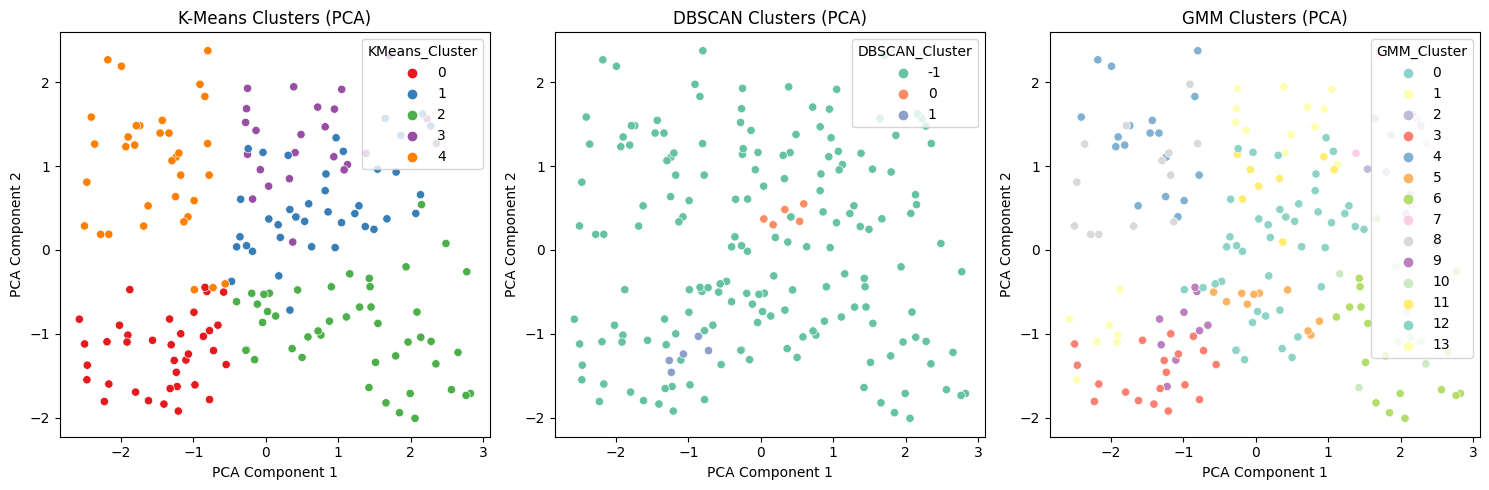

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='Set1', data=data)
plt.title('K-Means Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 3, 2)
sns.scatterplot(x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='Set2', data=data)
plt.title('DBSCAN Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 3, 3)
sns.scatterplot(x='PCA1', y='PCA2', hue='GMM_Cluster', palette='Set3', data=data)
plt.title('GMM Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()

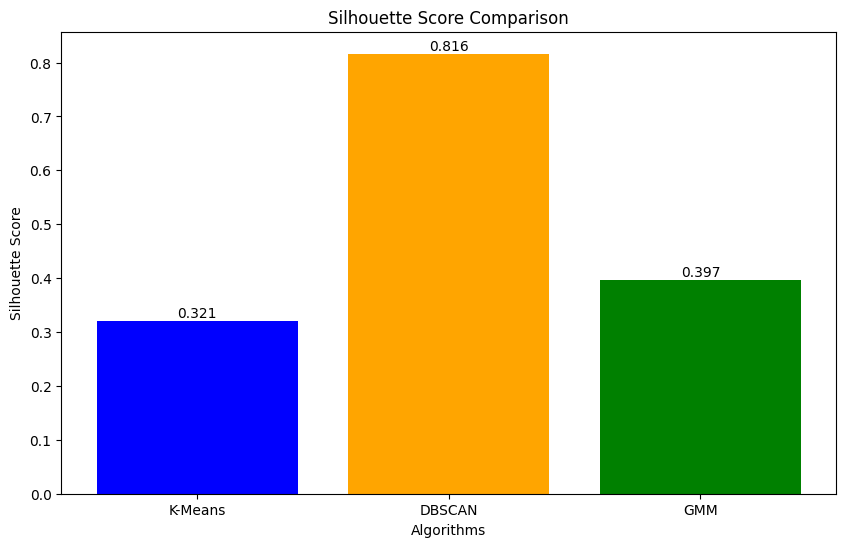

In [26]:
algorithms = ['K-Means', 'DBSCAN', 'GMM']
silhouette_scores = [kmeans_silhouette, dbscan_silhouette, gmm_silhouette]

plt.figure(figsize=(10, 6))
plt.bar(algorithms, silhouette_scores, color=['blue', 'orange', 'green'])
plt.xlabel('Algorithms')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Comparison')
for i, score in enumerate(silhouette_scores):
    plt.text(i, score, f'{score:.3f}', ha='center', va='bottom' if score > 0 else 'top')
plt.show()